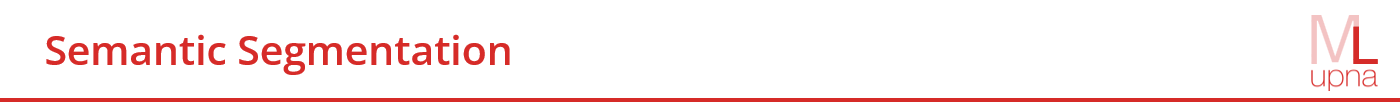

In this exercise, you will learn the fundamentals of <span style="color:#D52B29">semantic segmentation</span>, a core task in computer vision where the goal is to assign a <span style="color:#D52B29">class label</span> to each pixel of an image. Unlike classification, which predicts a single label for an entire image, or detection, which localizes objects with bounding boxes, semantic segmentation provides a much more detailed and structured understanding of visual content.

We will use the <span style="color:#D52B29">Clothing Co-Parsing (CCP)</span> dataset, which contains images of people annotated with pixel-level labels for different clothing categories. To simplify the problem and illustrate the task of segmentation, we will reduce the dataset into a <span style="color:#D52B29">binary problem</span> with only two classes: <span style="color:#D52B29">person</span> / <span style="color:#D52B29">background</span>.

![CCP Dataset](https://raw.githubusercontent.com/bearpaw/clothing-co-parsing/master/example.jpg)

Throughout the notebook, you will explore different approaches to segmentation:

- <span style="color:#D52B29">Sliding window</span> classification of the central pixel.

- <span style="color:#D52B29">Fully convolutional networks (FCNs)</span>.

- The <span style="color:#D52B29">U-Net</span> encoder-decoder architecture.

By the end of this practice, you will understand both the limitations of early approaches and the advantages of modern architectures in semantic segmentation.

One of the earliest strategies for <span style="color:#D52B29">semantic segmentation</span> is the <span style="color:#D52B29">sliding window approach</span>. In this method, a fixed-size window is moved across the image, and a classifier predicts the <span style="color:#D52B29">label of the central pixel</span> based on the content inside the window.

While simple to implement, this approach, as we will see in this section, has several drawbacks:

- It is <span style="color:#D52B29">computationally expensive</span> since the network runs on many overlapping patches.

- The model often struggles to capture <span style="color:#D52B29">global context</span> because predictions are based only on local neighborhoods.

Despite these limitations, the sliding window method provides an intuitive first step toward understanding pixel-level classification.

In [23]:
# Download from Huggingface
#!wget -q --show-progress https://huggingface.co/datasets/cayala/CCP/resolve/main/clothes.zip

# Extract to folder
#!unzip -q clothes.zip

# Remove the zip file
#!rm clothes.zip

In [24]:
# Buid dataset from folder structure

from glob import glob
import pandas as pd

images = glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df.image_path.apply(lambda x : x.replace('/images/', '/labels/').replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x : x.split('/')[2])
df.head()

,image_path,mask_path,set
0,./clothes/test/images/0851.jpg,./clothes/test/labels/0851.png,test
1,./clothes/test/images/0852.jpg,./clothes/test/labels/0852.png,test
2,./clothes/test/images/0853.jpg,./clothes/test/labels/0853.png,test
3,./clothes/test/images/0854.jpg,./clothes/test/labels/0854.png,test
4,./clothes/test/images/0855.jpg,./clothes/test/labels/0855.png,test


## <span style="color:#D52B29">Evaluation metrics in semantic segmentation</span>

In <span style="color:#D52B29">semantic segmentation</span>, we can still use some of the metrics seen in classification, such as <span style="color:#D52B29">accuracy</span> or the <span style="color:#D52B29">percentage of correctly classified pixels</span>.

In [ ]:
from sklearn.metrics import accuracy_score

"""y_hat = padded_y_hat_logits.argmax(-1)[pad:-pad, pad:-pad]

acc = accuracy_score(y_hat.ravel(), y.ravel())

f, ax = plt.subplots(1, 3, figsize=(15, 5))

f.suptitle(f'Accuracy: {acc:.2f}')

ax[0].imshow(x)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Image')

ax[1].imshow(y)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Ground Truth')

ax[2].imshow(y_hat)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Predicted mask')

plt.show()"""

NameError: name 'padded_y_hat_logits' is not defined

However, we are already aware of some of the problems that <span style="color:#D52B29">accuracy</span> can have, for example when working with <span style="color:#D52B29">imbalanced problems</span>. In semantic segmentation, it is common to use two other metrics that measure how well the <span style="color:#D52B29">predicted mask</span> matches the <span style="color:#D52B29">ground truth mask</span>.

- <span style="color:#D52B29">Intersection over Union (IoU)</span>
- <span style="color:#D52B29">Dice Coefficient / F1-score</span>

Undoubtedly, the most widely used metric is <span style="color:#D52B29">IoU</span> (Intersection over Union). It basically measures the number of <span style="color:#D52B29">pixels shared</span> between the two masks divided by the total number of pixels predicted as positive in both masks.

<span style="color:#D52B29">Note:</span> In the case of multiple classes, the <span style="color:#D52B29">IoU</span> is calculated for each class individually and then their mean is computed. This metric is known as <span style="color:#D52B29">mean IoU (mIoU)</span>.

Next, we will try to illustrate this metric using the results from the previous test.

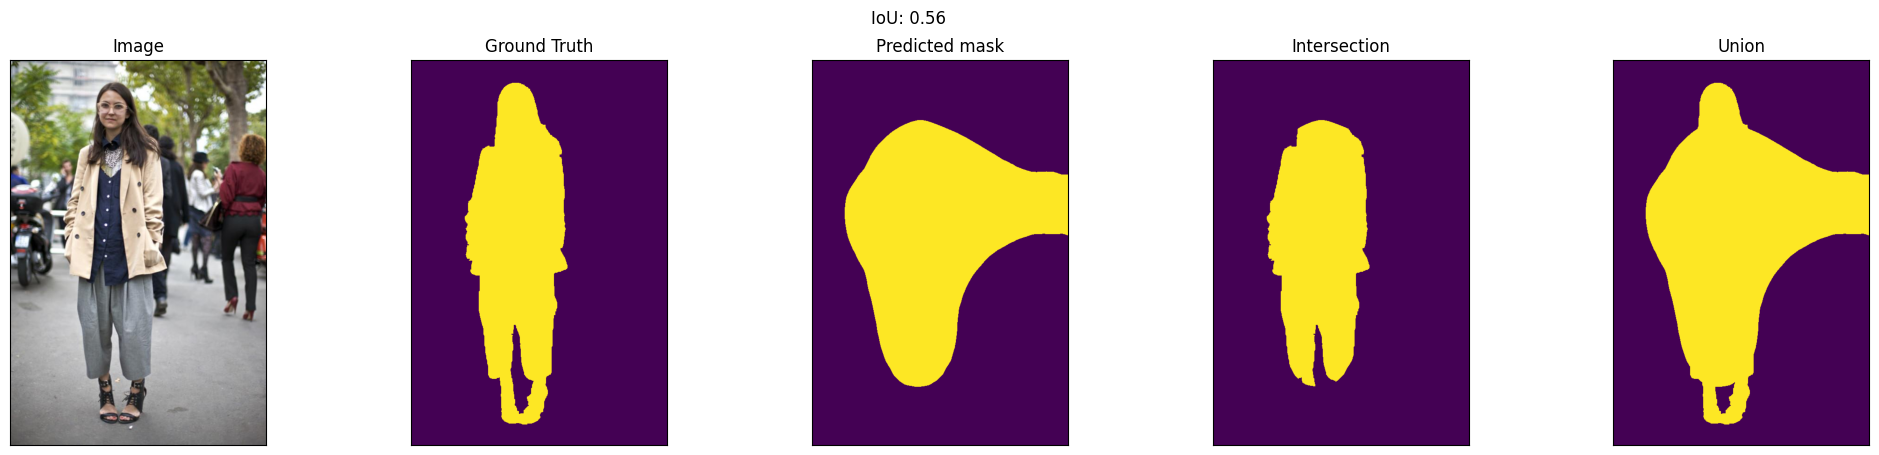

In [ ]:
"""f, ax = plt.subplots(1, 5, figsize=(25, 5))

intersection = np.logical_and(y, y_hat).numpy()
union = np.logical_or(y, y_hat).numpy()

iou = np.sum(intersection) / np.sum(union)

f.suptitle(f'IoU: {iou:.2f}')

ax[0].imshow(x)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Image')

ax[1].imshow(y)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Ground Truth')

ax[2].imshow(y_hat)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Predicted mask')

ax[3].imshow(intersection)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_title('Intersection')

ax[4].imshow(union)
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_title('Union')

plt.show()"""

As we can see, <span style="color:#D52B29">IoU</span> is a <span style="color:#D52B29">strict metric</span>, in the sense that small errors can significantly penalize the score. The <span style="color:#D52B29">maximum value</span> it can take is 1, while the <span style="color:#D52B29">minimum</span> is 0.

Finally, as with other metrics, it is not necessary to calculate <span style="color:#D52B29">IoU</span> manually, since we can use the <span style="color:#D52B29">jaccard_score</span>
 function from scikit-learn, which is equivalent to IoU (the name used depends on the application domain).

<span style="color:#D52B29">Note:</span> To compute the metric, the masks must be passed as <span style="color:#D52B29">flattened vectors</span>.

In [ ]:
# from sklearn.metrics import jaccard_score
# iou = jaccard_score(y_hat.ravel(), y.ravel())
# print(f'IoU {iou:.2f}')

IoU 0.56


The other widely used metric in <span style="color:#D52B29">semantic segmentation</span> is the <span style="color:#D52B29">Dice score</span>. We are already familiar with this metric, as in classification it corresponds to the <span style="color:#D52B29">F1-score</span>. If we look closely, we can see that its formulation is very similar to that of <span style="color:#D52B29">IoU</span>. In fact, both are correlated and one can be calculated from the other ([recommended reading on StackExchange](https://stats.stackexchange.com/a/276144)):

$$
\text{Dice} = \frac{2 \cdot \text{IoU}}{\text{IoU} + 1}
$$

Depending on how the metrics are averaged across all examples, there can be differences between using one or the other, as <span style="color:#D52B29">IoU</span> tends to penalize more heavily the severe errors.

In [ ]:
# dice = np.sum(2 * intersection) / (np.sum(y) + np.sum(y_hat.numpy()))
# print(f'Dice {dice:.4f}')

Dice 0.7144


In [ ]:
# dice = (2 * iou) / (iou + 1)
# print(f'Dice {dice:.4f}')

Dice 0.7144


In [ ]:
# from sklearn.metrics import f1_score
# dice = f1_score(y_hat.ravel(), y.ravel())
# print(f'Dice {dice:.4f}')

Dice 0.7144


<span style="color:#D52B29">General note on metrics:</span> When we want to compute metrics for multiple images, it is most common to calculate the metric for <span style="color:#D52B29">each image individually</span> and then compute the <span style="color:#D52B29">mean value</span> across all images. The same applies to <span style="color:#D52B29">loss functions</span>.

Finally, since these metrics are calculated from the elements of the <span style="color:#D52B29">confusion matrix</span> (true positives, false positives, etc.), we can compute <span style="color:#D52B29">masks</span> for each element and visualize them. This allows us to <span style="color:#D52B29">see where the model is correct or failing</span>, which can provide insights into how to <span style="color:#D52B29">improve its performance</span>.

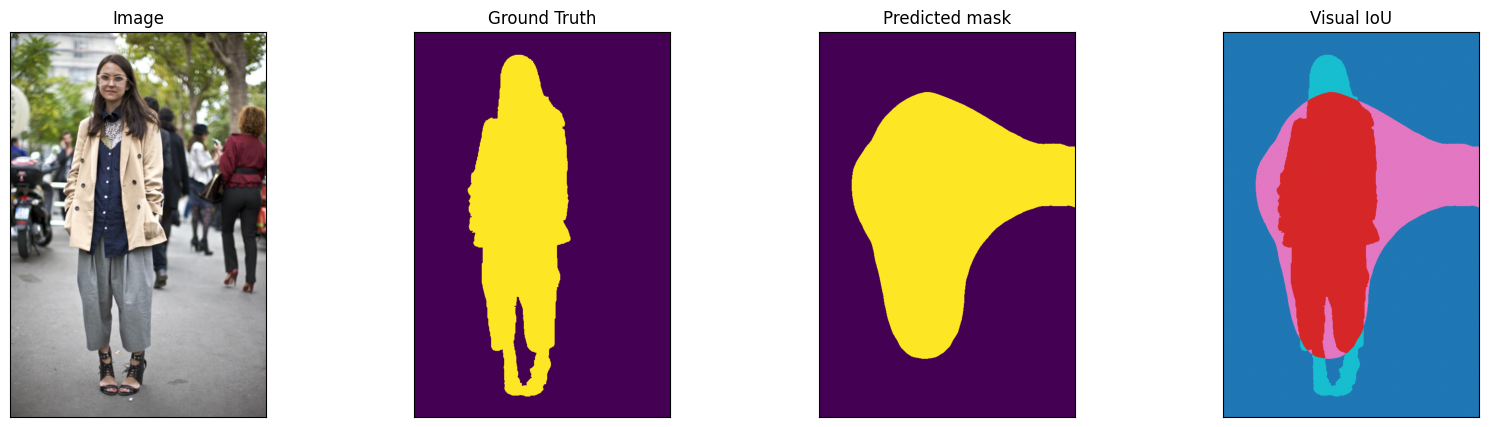

In [ ]:
# tp = np.logical_and(y, y_hat).numpy().astype(bool)
# fp = np.logical_and(~y, y_hat == 1).numpy().astype(bool)
# fn = np.logical_and(y, y_hat==0).numpy().astype(bool)

# visual_iou = np.zeros_like(y, dtype='uint8')
# visual_iou[tp] = 1
# visual_iou[fp] = 2
# visual_iou[fn] = 3

# f, ax = plt.subplots(1, 4, figsize=(20, 5))

# ax[0].imshow(x)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# ax[0].set_title('Image')

# ax[1].imshow(y)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# ax[1].set_title('Ground Truth')

# ax[2].imshow(y_hat)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# ax[2].set_title('Predicted mask')

# ax[3].imshow(visual_iou, vmin=0, vmax=3, cmap=plt.cm.tab10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# ax[3].set_title('Visual IoU')

# plt.show()

Returning to the previous experiment, we will calculate these <span style="color:#D52B29">metrics</span> as well as the <span style="color:#D52B29">inference time</span>. This will allow us to compare it with the two strategies we still have to explore. In this case, due to the <span style="color:#D52B29">high inference time</span>, we will only compute the metrics for the <span style="color:#D52B29">first image</span>.

In [ ]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import jaccard_score
# from sklearn.metrics import f1_score

# acc  = accuracy_score(y_hat.ravel(), y.ravel())
# iou  = jaccard_score(y_hat.ravel(), y.ravel())
# dice = f1_score(y_hat.ravel(), y.ravel())

# print(f'Pixel Accuracy  {acc*100:.2f}')
# print(f'IoU              {iou:.2f}')
# print(f'Dice             {dice:.2f}')
# print(f'Inf. time      ~30min')

Pixel Accuracy  83.89
IoU              0.56
Dice             0.71
Inf. time      ~30min


## <span style="color:#D52B29">Fully Convolutional Networks (FCNNs)</span>

As we have seen, the previous approach, although relatively accurate for the current problem, is <span style="color:#D52B29">computationally unfeasible</span> due to the large number of repeated operations. Therefore, it is necessary to explore alternative strategies.

An intuitive idea would be to have the <span style="color:#D52B29">CNN output a mask</span> the same size as the input image. We could attempt this directly from the last convolutional layer of the ResNet we used, but the problem is that most networks use <span style="color:#D52B29">pooling</span> to reduce the dimensions of the feature maps they operate on, which also allows a more global view of the image. Trying to reconstruct a precise mask from this point does not seem optimal.

This is where the concept of <span style="color:#D52B29">Fully Convolutional Neural Networks (FCNNs)</span> comes into play. In these networks, <span style="color:#D52B29">pooling layers are avoided</span> so that the output has the <span style="color:#D52B29">same dimensions as the input</span>, allowing us to produce a <span style="color:#D52B29">full-image mask</span> as output. This solves the problem of repeated computations that we encountered with the patch-based strategy.

If we analyze this approach, we quickly realize that it also has <span style="color:#D52B29">limitations</span>. Operating on the <span style="color:#D52B29">full image dimensions</span> throughout the network makes the computations very expensive. Therefore, using <span style="color:#D52B29">deep networks with many convolutional layers</span> also becomes challenging. Nevertheless, we are going to test it and see the results.

The first thing we will do is modify the dataset so that, instead of returning the <span style="color:#D52B29">class of the central pixel</span>, it returns the <span style="color:#D52B29">mask corresponding to the 224×224 window</span> that we randomly extracted.

In this case, we need to modify both the <span style="color:#D52B29">input image</span> and the <span style="color:#D52B29">ground truth mask</span> in the same way (except for normalization). For example, if we apply augmentations (so far we have not) and rotate the image by 90 degrees, we must also rotate the mask by 90 degrees to keep them aligned.

Moreover, the <span style="color:#D52B29">224×224 crop</span> can also be performed using the <span style="color:#D52B29">torchvision transformations</span>. To apply them simultaneously to both the image and the mask, we need an intermediate step: converting them into the <span style="color:#D52B29">PIL format</span>.

It is worth stressing that although for training random patches suffice, for evaluation (validation and testing sets) we need to consider all the <span style="color:#D52B29">224×224 patches</span> within the images discretely, so that every epoch we evaluate the model on the exact same patches. To achieve this, we need to slightly modify the behavior of our <span style="color:#D52B29">Dataset class</span>.

First, we will introduce a parameter <span style="color:#D52B29">mode</span>, which will indicate whether we are training or evaluating. If in training mode, the Dataset will work as before (sampling random patches). However, if in evaluation mode, the Dataset will rely on an additional <span style="color:#D52B29">coordinates column</span> in the dataframe, which specifies the location from which to crop the image.

Later, in the <span style="color:#D52B29">DataModule</span>, we will compute for each image all the coordinates of the non-overlapping <span style="color:#D52B29">224×224 tiles</span> (all possible windows that fully cover the image). This results in a list of coordinates per image, which we will then expand into individual rows (one per coordinate). Consequently, the evaluation dataframe will contain as many rows as <span style="color:#D52B29">images × coordinates</span>.

In summary, each row in the evaluation dataframe will now include not only the <span style="color:#D52B29">image and mask paths</span> as usual, but also an additional column containing a tuple of <span style="color:#D52B29">coordinates</span> that indicates the region to crop.

As we mentioned earlier, in the <span style="color:#D52B29">DataModule</span> we need to generate, for each image, the list of coordinates corresponding to the <span style="color:#D52B29">224×224 tiles</span> on which we will evaluate the model. To do so, we will use the function <span style="color:#D52B29">patch_origins()</span> that we defined previously.

Once we obtain this list of coordinates, we will expand the dataset, creating as many rows as <span style="color:#D52B29">image–coordinate</span> combinations exist. We will instantiate the datasets that need this evaluation procedure (validation and test) using these “new” datasets and setting the <span style="color:#D52B29">mode</span> parameter of the <span style="color:#D52B29">Dataset</span> accordingly.

Finally, in the transformations for these evaluation datasets we will remove the <span style="color:#D52B29">random cropping</span>, since the coordinates are now explicitly provided.


While the <span style="color:#D52B29">training dataset</span> generates random <span style="color:#D52B29">224×224 patches</span> from each image, the <span style="color:#D52B29">validation</span> and <span style="color:#D52B29">test datasets</span> systematically cover all possible <span style="color:#D52B29">224×224 patches without overlap</span>.

Once the <span style="color:#D52B29">Datasets</span> and <span style="color:#D52B29">DataModule</span> are defined, we proceed to implement the model: a <span style="color:#D52B29">Fully Convolutional Neural Network (FCN)</span>. For simplicity, we will build a very lightweight architecture, entirely convolutional, where the number of convolutional blocks can be adjusted through the parameter <span style="color:#D52B29">n_blocks</span>.


In [ ]:
class FCN(nn.Module):

    def __init__(self, n_class, n_blocs):
        super().__init__()
        self.n_class = n_class
        self.n_blocs = n_blocs
        
        k_size = 16
        layers = [nn.Conv2d(3, k_size, 3, 1, 1)]
        for i in np.arange(1, n_blocs):
            layers += [nn.ReLU(inplace=True), 
                       nn.Conv2d(k_size, k_size, 3, 1, 1), 
                       nn.BatchNorm2d(k_size)] 
        layers += [nn.ReLU(inplace=True), 
                   nn.Conv2d(k_size, k_size, 3, 1, 1), 
                   nn.Conv2d(k_size, n_class, 3, 1, 1)]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

The parameter <span style="color:#D52B29">n_class</span> determines the number of neurons in the <span style="color:#D52B29">final layer</span>, i.e., the number of target classes. In this case, we can choose either 1 or 2. Depending on the choice, we must use a different <span style="color:#D52B29">loss function</span>: <span style="color:#D52B29">Binary Cross Entropy</span> for 1 class, or <span style="color:#D52B29">Cross Entropy</span> for 2 classes.

Here, we will use 2 neurons to remain consistent with the first experiment. When we instantiate the model and pass a random test example, we observe that it returns a <span style="color:#D52B29">predicted segmentation mask</span> with the same dimensions as the original image, which is precisely what we aimed to achieve with the <span style="color:#D52B29">FCNs</span>.


In [ ]:
model = FCN(n_class=2, n_blocs=8)

x = torch.rand(1, 3, 256, 256)
y_hat = model(x)
y_hat.shape

torch.Size([1, 2, 256, 256])

Finally, we need to adapt the <span style="color:#D52B29">LightningModule</span> to work with the <span style="color:#D52B29">FCN</span> we just defined and for <span style="color:#D52B29">semantic segmentation tasks</span>. This involves modifying the way the <span style="color:#D52B29">loss function</span> is computed to account for per-pixel classification.


In [ ]:
from torch.nn import functional as F
from collections import defaultdict

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        
        # Creating model
        self.model = FCN(n_class=2, n_blocs=8)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {"optimizer": optimizer}

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y.squeeze(1)) # y: (BS, 1, H, W) -> (BS, H, W)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y.squeeze(1))
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear() 
		

Now, we have all the necessary components to <span style="color:#D52B29">train the model</span>. Let’s go ahead.

We will now load the best model and perform inference as before, in order to compute metrics and compare this approach with the previous one.

In [ ]:
# Load the best model
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU
model.eval()

LightningModule(
  (model): FCN(
    (model): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace=True)
      (14): Conv2d(16, 16, kernel_size=(

In [ ]:
ps = 256 # Imagenet Resizes to 256

inf_transforms = T.Compose([
    # T.Resize(size=(256, 256)),    
    T.ToImage(), 
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

metric_dict = []

test_df = df.query('set == "test"')

mb = master_bar(test_df.iterrows(), total=test_df.shape[0])

for i, r in mb:

    # Read image and mask
    x = imread(r.image_path)
    y = imread(r.mask_path)
    
    # Convert into binary mask and take central pixel value
    y = (y != np.array([69,  6, 90])).any(-1)
    
    # Compute origins
    h, w = y.shape
    coords = DataModule.patch_origins(None, h, w, ps=ps, overlap=1).tolist()

    # Initialize y_hat
    y_hat = torch.zeros((2, h, w), dtype=torch.float32)
    y_wei = torch.zeros((1, h, w), dtype=torch.uint8) # Times each pixel has been infered
    
    # Perform inference
    for (coord_x, coord_y) in progress_bar(coords, parent=mb):
            
        # Crop
        xi = x[coord_x:coord_x+ps, coord_y:coord_y+ps]
        
        # Convert to PIL image.
        xi = to_pil_image(xi.astype('float32'))
        
        # Apply transforms
        xi = inf_transforms(xi)

        # Forward
        with torch.no_grad():
            logits = model(xi.cuda(0).unsqueeze(0))
            logits = nn.Softmax(1)(logits).detach().cpu()[0]

        # Store predictions
        y_hat[:, coord_x:coord_x+ps, coord_y:coord_y+ps] += logits
        y_wei[:, coord_x:coord_x+ps, coord_y:coord_y+ps] += 1

    # Normalize logits and gen binary mask
    y_hat /= y_wei
    y_hat_bin = y_hat.argmax(0)

    # Compute metrics
    metric_dict.append({
        'pixel_acc': accuracy_score(y_hat_bin.ravel(), y.ravel()),
        'iou': jaccard_score(y_hat_bin.ravel(), y.ravel()),
        'dice': f1_score(y_hat_bin.ravel(), y.ravel())
    })

Epoch 154/154 :                                                                       

In [ ]:
pd.DataFrame.from_records(metric_dict).mean(0)

pixel_acc    0.828692
iou          0.546249
dice         0.688820
dtype: float64

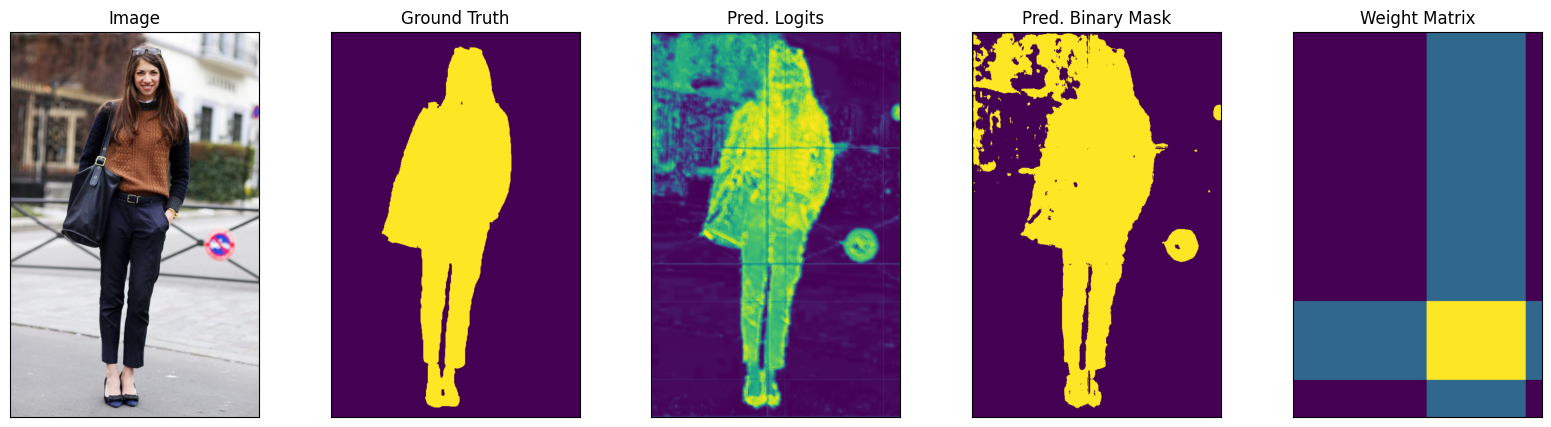

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(x)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Image')

ax[1].imshow(y)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Ground Truth')

ax[2].imshow(y_hat[1])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Pred. Logits')

ax[3].imshow(y_hat_bin)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_title('Pred. Binary Mask')

ax[4].imshow(y_wei[0])
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_title('Weight Matrix')

plt.show()

As we can see, the results are not ideal. The truth is that, to make this feasible to run in a short time we used a very small network (only 19K parameters vs. 21M in ResNet18) and performed few training iterations. This is a result that can definitely be improved (and you can try!), but there is a more efficient and effective alternative that solves these issues. We will see it next.

| Experiment      | Inference time    | Sample | Accuracy | IoU  | Dice |
|:---------------:|:----------------:|:------:|:--------:|:----:|:----:|
| Sliding Window  | 30m* / image     | 0851   | 83.89    | 0.56 | 0.71 |
| FCNN            | 1s / image       | 0851   | 79.76    | 0.34 | 0.51 |

*Inference time for the sliding window approach may be reduced applying batches.

## <span style="color:#D52B29">Encoder-Decoder Architecture</span>

In previous sections, we saw that convolutional networks used for classification extract information from the original image at multiple levels. Each level compresses information more, producing richer features. However, in the first strategy (sliding window), this does not help for segmentation since we would need to classify pixel by pixel.

The second strategy we explored does not compress the information and works at the original resolution, allowing segmentation in a single pass. Unfortunately, it is also not ideal due to the high computational cost.

The solution is to <span style="color:#D52B29">combine both approaches</span>. We will use <span style="color:#D52B29">FCNNs that internally compress and decompress information</span>. Pooling layers reduce dimensionality (<span style="color:#D52B29">encoder</span>), while deconvolution or upsampling layers restore it (<span style="color:#D52B29">decoder</span>). Additionally, most architectures include <span style="color:#D52B29">skip-connections</span> that transfer information from the encoder to the decoder for more precise reconstruction.

Among encoder-decoder architectures, there are many variations. Fastai focuses on the most widely used one due to its strong generalization across tasks: the <span style="color:#D52B29">U-Net</span>, named after the "U" shape of its structure, as illustrated below.

![Arquitectura Unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Imagen from: [U-Net: Convolutional Networks for Biomedical Image Segmentation
](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/#:~:text=The%20u%2Dnet%20is%20convolutional,and%20precise%20segmentation%20of%20images.&text=U%2Dnet%20architecture%20(example%20for,on%20top%20of%20the%20box.).

As we can see, the architecture starts with a CNN-like <span style="color:#D52B29">encoder</span>, consisting of convolutional and pooling layers. This part can be replaced with any CNN we’ve seen before (e.g., <span style="color:#D52B29">ResNet</span>), also called the <span style="color:#D52B29">backbone</span>. After compression, the <span style="color:#D52B29">decoder</span> uses upsampling and convolutional layers to restore spatial resolution. The horizontal arrows are <span style="color:#D52B29">skip-connections</span>, which pass features from each encoder level to the corresponding decoder layer, improving spatial accuracy.

Although there are technical complexities like undoing pooling (<span style="color:#D52B29">upsampling</span>) or implementing deconvolutions, these details are abstracted when using Fastai’s <span style="color:#D52B29">U-Net</span> implementation, so we will focus on its practical use rather than the low-level operations.

In [26]:
import pytorch_lightning as pl
import os
import pandas as pd
import numpy as np
import torch
import matplotlib as plt
from torchvision.models import ResNet18_Weights
from skimage.io import imread  # or your preferred image loader



To implement the <span style="color:#D52B29">U-Net</span> and other more advanced semantic segmentation architectures, we will use the <span style="color:#D52B29">Segmentation Models PyTorch</span> library. This library allows us to easily choose different encoders and configure various internal parameters of the network.

Next, we will see how to instantiate a <span style="color:#D52B29">U-Net</span> that uses a <span style="color:#D52B29">ResNet18 encoder</span> pre-trained on ImageNet.

In [27]:
DATA_DIR = 'clothes'
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_name'].tolist()
# Rewriting 'null' class to prevent a NaN value 
class_names[0] = 'null'
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('\nClass Names: ', class_names)
print('\nClass RGB values: ', class_rgb_values)
def rgb_to_class(mask, class_rgb_values):
    """
    Convert an RGB segmentation mask to a class index mask.
    mask: (H, W, 3)
    returns: (H, W) with class IDs.
    """
    h, w, _ = mask.shape
    mask_flat = mask.reshape(-1, 3)

    class_id_mask = np.zeros((h*w,), dtype=np.uint8)

    for class_id, rgb in enumerate(class_rgb_values):
        matches = np.all(mask_flat == rgb, axis=-1)
        class_id_mask[matches] = class_id

    return class_id_mask.reshape(h, w)


def class_to_rgb(mask, class_rgb_values):
    """
    Convert a class-index mask (H,W) back to an RGB mask (H,W,3)
    """
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, rgb in enumerate(class_rgb_values):
        rgb_mask[mask == class_id] = rgb

    return rgb_mask

class CCPDataset(torch.utils.data.Dataset):

    def __init__(self, df, class_rgb_values=class_rgb_values, patch_size=224, transforms=None):
        super(CCPDataset, self).__init__()
        self.df = df
        self.ps = patch_size
        self.transforms = transforms
        self.class_rgb_values = class_rgb_values

    def __random_crop__(self, img, mask):
        H, W, _ = img.shape
        
        y = np.random.randint(0, H - self.ps + 1)
        x = np.random.randint(0, W - self.ps + 1)
        
        return (
            img[y:y+self.ps, x:x+self.ps, :],
            mask[y:y+self.ps, x:x+self.ps, :]
        )

    def __getitem__(self, idx):

        r = self.df.iloc[idx]

        # Read image and mask
        x = imread(r.image_path)
        y = imread(r.mask_path)

        # Take random patch
        x, y = self.__random_crop__(x, y)

        # Convert mask to class IDs
        y = rgb_to_class(y, self.class_rgb_values)

        # Convert to tensors
        x = torch.from_numpy(x.transpose(2, 0, 1)).float()  # (C,H,W)
        y = torch.from_numpy(y).long()                      # (H,W)

        # Apply transforms (image only)
        if self.transforms:
            x = self.transforms(x)

        return x, y

    def __len__(self):
        return len(self.df)

    def __show_item__(self, x, y, idx=None):
        """
        Display an image and its corresponding segmentation mask.
        x: tensor (C,H,W)
        y: tensor (H,W) with class IDs
        idx: optional, dataset index
        """
        # Convert image to HWC for plotting
        x_np = x.permute(1, 2, 0).numpy().astype(np.uint8)
        
        # Convert class mask to RGB
        y_rgb = class_to_rgb(y.numpy(), self.class_rgb_values)
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(x_np)
        plt.title(f"Image {idx}" if idx is not None else "Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(y_rgb)
        plt.title("Mask")
        plt.axis('off')
        
        plt.show()



class DataModule(pl.LightningDataModule):
    def __init__(self, df, bs, ps, num_workers=4):
        super().__init__()
        self.df = df
        self.bs = bs
        self.ps = ps
        self.num_workers = num_workers

    def setup(self, stage): # Data preparation and transforms
        transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
        self.train_ds = CCPDataset(df=df.query('set == "train"'), patch_size=self.ps, transforms=transforms)
        self.valid_ds = CCPDataset(df=df.query('set == "valid"'), patch_size=self.ps, transforms=transforms)
        self.test_ds = CCPDataset(df=df.query('set == "test"'), patch_size=self.ps, transforms=transforms)

    def train_dataloader(self): return torch.utils.data.DataLoader(self.train_ds, batch_size=self.bs, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self): return torch.utils.data.DataLoader(self.valid_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self): return torch.utils.data.DataLoader(self.test_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers)


All dataset classes and their corresponding RGB values in labels:

Class Names:  ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

Class RGB values:  [[69, 6, 90], [70, 12, 95], [71, 18, 101], [72, 25, 107], [72, 30, 112], [72, 35, 116], [71, 40, 120], [70, 47, 124], [69, 52, 127], [68, 57, 130], [66, 61, 132], [64, 67, 135], [62, 72, 136], [61, 76, 137], [58, 82, 139], [56, 86, 139], [54, 90, 140], [52, 94, 141], [50, 99, 141], [48, 103, 141], [46, 107, 142], [

In [28]:
import segmentation_models_pytorch as smp

In [29]:
model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [30]:
x = torch.rand(1, 3, 256, 256)
y_hat = model(x)
y_hat.shape

torch.Size([1, 59, 256, 256])

We are now going to modify the <span style="color:#D52B29">LightningModule</span> to make use of this new <span style="color:#D52B29">U-Net model</span> and train it with the same parametrization as in the previous experiments, ensuring a <span style="color:#D52B29">fair comparison</span>.

In [31]:
class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        
        # Creating model
        self.model = smp.Unet(
            encoder_name='resnet18',
            encoder_weights='imagenet',
            in_channels=3,
            classes=2
        )

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {"optimizer": optimizer}

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        if y.max() >= 59:
            print(f"¡ALERTA! Encontrada clase {y.max()} en el batch {batch_idx}")
        loss = F.cross_entropy(logits, y) # y: (BS, 1, H, W) -> (BS, H, W)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        if y.max() >= 59:
            print(f"¡ALERTA! Encontrada clase {y.max()} en el batch {batch_idx}")
        loss = F.cross_entropy(logits, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear() 

In [32]:
from lightning.pytorch.loggers import CSVLogger
from torch.nn import functional as F
from collections import defaultdict

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Intantiate LightningModule
lightning_module = LightningModule()

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="experiments/ccp_unet")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=30, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = DataModule(df, bs=64, ps=224)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | Unet | 14.3 M | train
---------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)
140       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


   epoch  step  train_loss   val_loss
0      0    10    0.417222  39.114971
1      1    21    0.215378   1.939123
2      2    32    0.186887   0.372676
3      3    43    0.153339   0.134510
4      4    54    0.136732   0.136498


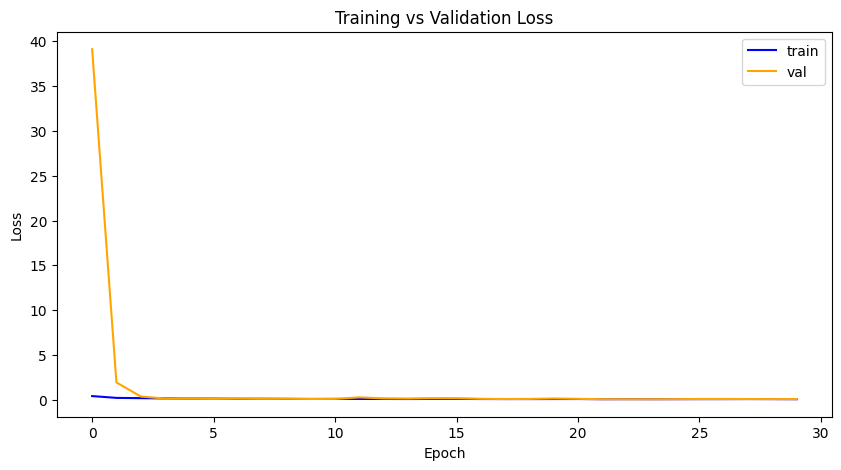

In [ ]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

We will now load the best model and perform inference as before, in order to compute metrics and compare this approach with the previous ones.

In [ ]:
# Load the best model
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU
model.eval()

LightningModule(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [ ]:
ps = 256 # Imagenet Resizes to 256

inf_transforms = T.Compose([
    # T.Resize(size=(256, 256)),    
    T.ToImage(), 
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

metric_dict = []

test_df = df.query('set == "test"')

mb = master_bar(test_df.iterrows(), total=test_df.shape[0])

for i, r in mb:

    # Read image and mask
    x = imread(r.image_path)
    y = imread(r.mask_path)
    
    # Convert into binary mask and take central pixel value
    y = (y != np.array([69,  6, 90])).any(-1)
    
    # Compute origins
    h, w = y.shape
    coords = DataModule.patch_origins(None, h, w, ps=ps, overlap=1).tolist()

    # Initialize y_hat
    y_hat = torch.zeros((2, h, w), dtype=torch.float32)
    y_wei = torch.zeros((1, h, w), dtype=torch.uint8) # Times each pixel has been infered
    
    # Perform inference
    for (coord_x, coord_y) in progress_bar(coords, parent=mb):
            
        # Crop
        xi = x[coord_x:coord_x+ps, coord_y:coord_y+ps]
        
        # Convert to PIL image.
        xi = to_pil_image(xi.astype('float32'))
        
        # Apply transforms
        xi = inf_transforms(xi)

        # Forward
        with torch.no_grad():
            logits = model(xi.cuda(0).unsqueeze(0))
            logits = nn.Softmax(1)(logits).detach().cpu()[0]

        # Store predictions
        y_hat[:, coord_x:coord_x+ps, coord_y:coord_y+ps] += logits
        y_wei[:, coord_x:coord_x+ps, coord_y:coord_y+ps] += 1

    # Normalize logits and gen binary mask
    y_hat /= y_wei
    y_hat_bin = y_hat.argmax(0)

    # Compute metrics
    metric_dict.append({
        'pixel_acc': accuracy_score(y_hat_bin.ravel(), y.ravel()),
        'iou': jaccard_score(y_hat_bin.ravel(), y.ravel()),
        'dice': f1_score(y_hat_bin.ravel(), y.ravel())
    })

Epoch 154/154 :                                                                       

In [ ]:
pd.DataFrame.from_records(metric_dict).mean(0)

pixel_acc    0.967562
iou          0.890815
dice         0.937486
dtype: float64

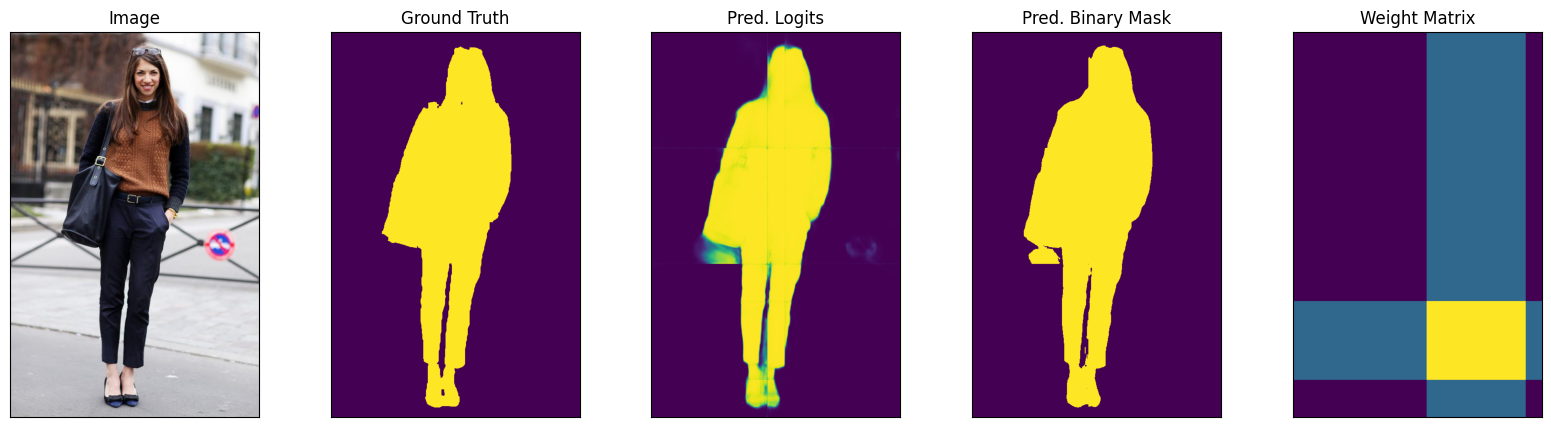

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(x)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Image')

ax[1].imshow(y)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Ground Truth')

ax[2].imshow(y_hat[1])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Pred. Logits')

ax[3].imshow(y_hat_bin)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_title('Pred. Binary Mask')

ax[4].imshow(y_wei[0])
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_title('Weight Matrix')

plt.show()

As we can see, the results obtained with <span style="color:#D52B29">U-Net</span> are the best so far. We not only gain in <span style="color:#D52B29">efficiency</span> but also in <span style="color:#D52B29">accuracy</span>. This strategy is therefore the one we should follow to tackle <span style="color:#D52B29">semantic segmentation</span> problems.

| Experiment      | Inference time    | Sample | Accuracy | IoU  | Dice |
|:---------------:|:----------------:|:------:|:--------:|:----:|:----:|
| Sliding Window  | 30m* / image     | 0851   | 83.89    | 0.56 | 0.71 |
| FCNN            | 1s / image       | 0851   | 79.76    | 0.34 | 0.51 |
| U-Net           | 1s / image       | 0851   | 94.98    | 0.81 | 0.89 |

*Inference time for the sliding window approach may be reduced applying batches.

There are, of course, other <span style="color:#D52B29">semantic segmentation</span> architectures besides U-Net (although most share the same <span style="color:#D52B29">encoder-decoder</span> principle). The <span style="color:#D52B29">segmentation models pytorch</span> library makes it easy to try out different configurations. I encourage you to experiment with them!

## <span style="color:#D52B29">Summary</span>

In this exercise, you have learned the fundamentals of <span style="color:#D52B29">semantic segmentation</span>, a key task in <span style="color:#D52B29">computer vision</span> where the goal is to assign a <span style="color:#D52B29">class label</span> to each pixel of an image. Unlike <span style="color:#D52B29">classification</span>, which predicts a single label for an entire image, or <span style="color:#D52B29">detection</span>, which localizes objects with bounding boxes, segmentation provides a much more detailed and structured understanding of visual content.

We have worked with the <span style="color:#D52B29">Clothing Co-Parsing (CCP)</span> dataset, simplified into a <span style="color:#D52B29">binary problem</span> with only two classes: <span style="color:#D52B29">person</span> / <span style="color:#D52B29">background</span>.

Throughout the notebook, you explored three different approaches to segmentation:

- <span style="color:#D52B29">Sliding window</span> classification of the central pixel.

- <span style="color:#D52B29">Fully convolutional networks (FCNs)</span>.

- The <span style="color:#D52B29">U-Net</span> encoder-decoder architecture.

You have seen how early methods, like the sliding window, can be conceptually simple but computationally inefficient. The FCN approach introduced a step forward, producing full-resolution masks in a single pass, but still suffered from accuracy issues. Finally, the U-Net architecture combined the strengths of both approaches by compressing and then reconstructing the information with the help of <span style="color:#D52B29">skip-connections</span>, leading to the best results both in terms of <span style="color:#D52B29">efficiency</span> and <span style="color:#D52B29">accuracy</span>.

As a takeaway, you should now understand not only how different architectures perform in practice, but also why <span style="color:#D52B29">encoder-decoder models</span> such as <span style="color:#D52B29">U-Net</span> have become the standard in semantic segmentation. Finally, remember that there are many other segmentation architectures beyond U-Net (most sharing the encoder-decoder principle), and the <span style="color:#D52B29">segmentation models pytorch</span> library makes it easy to experiment with them.